# Sampling NIH XRays to somewhat balance the labels

- Note: Since this is a multi-label multi-classification, therefore vanilla frequency based sampling will not balance labels.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
from PIL import Image
from typing import Callable, Union, Sequence

In [3]:
from chest_xray_diagnosis import get_root_path
from chest_xray_diagnosis.metadata import process

In [4]:
PROJECT_PATH = get_root_path()
METADATA_PATH = os.path.join(PROJECT_PATH, "metadata", "NIH")
DATA_PATH = os.path.join("/scratch", "mittal.nit", "nih-chestxrays", "xrays", "images")

In [5]:
metadata = pd.read_csv(os.path.join(METADATA_PATH, "Data_Entry_2017_v2020.csv"))
metadata.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [6]:
metadata.set_index("Image Index", inplace=True)

In [7]:
metadata.head()

,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
Image Index,,,,,,,,,,
00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [8]:
print(f"Number of samples in metadata: {len(metadata)}")
print(f"Number of xray images: {len(np.unique(os.listdir(DATA_PATH)))}")
print(f"Number of unique image indices: {len(metadata.index.unique())}")
print(f"Number of unique patients : {len(metadata['Patient ID'].unique())}")

Number of samples in metadata: 112120
Number of xray images: 112120
Number of unique image indices: 112120
Number of unique patients : 30805


<font color="blue"> Note: Multiple XRays available for same patient.
    Same patient should not be present in both train, test and validation set in-order to prevent data leakage.

## Onhot Encoding labels

In [9]:
# one hot encoding for labels
onehotlabels = process.get_dummies(
    metadata["Finding Labels"],
    validate_io_schema=True)
onehotlabels.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Image Index,,,,,,,,,,,,,,,
00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
00000002_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
00000003_001.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


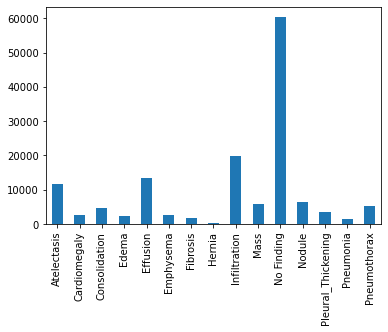

In [10]:
onehotlabels.sum(axis=0).plot.bar()
plt.show()

In [11]:
labels = onehotlabels.melt(ignore_index=False, var_name="label")
labels = labels[labels["value"]!=0][["label"]]
labels.head()

,label
Image Index,
00000011_006.png,Atelectasis
00000013_030.png,Atelectasis
00000013_035.png,Atelectasis
00000019_000.png,Atelectasis
00000030_000.png,Atelectasis


In [12]:
labels.value_counts()

label             
No Finding            60361
Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                 6331
Mass                   5782
Pneumothorax           5302
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2776
Emphysema              2516
Edema                  2303
Fibrosis               1686
Pneumonia              1431
Hernia                  227
dtype: int64

In [13]:
labels = pd.merge(
    labels, 
    metadata[["Patient ID"]], 
    left_index=True, 
    right_index=True)
labels.head()

,label,Patient ID
Image Index,,
00000001_000.png,Cardiomegaly,1
00000001_001.png,Cardiomegaly,1
00000001_001.png,Emphysema,1
00000001_002.png,Cardiomegaly,1
00000001_002.png,Effusion,1


In [15]:
labels.groupby("label").agg({"Patient ID": ["count", pd.Series.nunique]})

Patient ID        
                        count nunique
label                                
Atelectasis             11559    4981
Cardiomegaly             2776    1566
Consolidation            4667    2150
Edema                    2303    1073
Effusion                13317    4275
Emphysema                2516    1046
Fibrosis                 1686    1260
Hernia                    227     134
Infiltration            19894    8035
Mass                     5782    2568
No Finding              60361   24907
Nodule                   6331    3394
Pleural_Thickening       3385    2006
Pneumonia                1431    1008
Pneumothorax             5302    1487

In [24]:
for lalbel in onehotlabels.columns

Index(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')

In [21]:
for label in 


np.random.choice(labels[labels["label"]=="Hernia"]["Patient ID"].unique(), size=30)

array([  385,  9507, 30235,  3029, 25936,  7352,  7352,  3240, 14895,
        3046, 26791,   111,  3046, 22013,  8350, 17136, 27671,  9368,
        3046,  8994, 21042, 13791, 12003, 15112, 29425,  9984, 18999,
       18347, 15580, 21943])

In [31]:
labels = labels.groupby("label").sample(n=2000, replace=True, random_state=None)
labels.head()

,label
Image Index,
00020318_021.png,Atelectasis
00009488_002.png,Atelectasis
00015338_007.png,Atelectasis
00002552_001.png,Atelectasis
00000831_001.png,Atelectasis


In [32]:
labels.value_counts()

label             
Atelectasis           2000
Cardiomegaly          2000
Consolidation         2000
Edema                 2000
Effusion              2000
Emphysema             2000
Fibrosis              2000
Hernia                2000
Infiltration          2000
Mass                  2000
No Finding            2000
Nodule                2000
Pleural_Thickening    2000
Pneumonia             2000
Pneumothorax          2000
dtype: int64

In [33]:
labels.reset_index().groupby("label").agg({"Image Index":["count",pd.Series.nunique]})

Image Index        
                         count nunique
label                                 
Atelectasis               2000    1854
Cardiomegaly              2000    1416
Consolidation             2000    1625
Edema                     2000    1373
Effusion                  2000    1866
Emphysema                 2000    1393
Fibrosis                  2000    1160
Hernia                    2000     227
Infiltration              2000    1912
Mass                      2000    1670
No Finding                2000    1964
Nodule                    2000    1711
Pleural_Thickening        2000    1545
Pneumonia                 2000    1071
Pneumothorax              2000    1674

<font color="blue"> Note: if during sampling the number of samples per label is greater than minimum number of distinct samples available for any label then all samples for that label are picked. 
    For ex. in this case, for <b>Hernia</b>, NIH dataset has 227 samples. 
    If we sample 2000 samples per label then samples are pciked from entire 227 samples of Hernia. 
    No samples for Hernia will be left for validation and testing.

## Generating train, test, validation set

In [72]:
t1 = pd.merge(t1,metadata["Patient ID"], left_index=True, right_index=True)

In [73]:
len(t1["Patient ID"].unique())

8379

In [74]:
median()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Image Index,,,,,,,,,,,,,,,
00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
00000002_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
00000003_001.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00030801_001.png,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
00030802_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
00030803_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [108]:
def sample_onehotlabels(
    onehotlabels: pd.core.frame.DataFrame,
    n: Union[Callable[Sequence, int], int]=np.min, 
    replace: bool=False,
    random_state: int=None):

    labels = onehotlabels.melt(var_name="label", ignore_index=False)
    labels = pd.DataFrame(labels[labels["value"]!=0]["label"])
    
    if not isinstance(n, int):
        n = int(n(labels.value_counts()))
    labels = labels.groupby("label").sample(n=n, replace=replace, random_state=random_state)
    
    
    return pd.merge(labels, onehotlabels, left_index=True, right_index=True, how="inner").drop("label", axis=1)

In [121]:
samples = sample_onehotlabels(onehotlabels, 200, False)

In [122]:
samples.sum(axis=0)

Atelectasis           621
Cardiomegaly          287
Consolidation         394
Edema                 318
Effusion              736
Emphysema             287
Fibrosis              251
Hernia                210
Infiltration          847
Mass                  383
No Finding            200
Nodule                380
Pleural_Thickening    325
Pneumonia             262
Pneumothorax          390
dtype: int64